# 作業1

[*********************100%***********************]  1 of 1 completed

Epoch 10/100, Loss: 0.1684
Epoch 20/100, Loss: 0.1564
Epoch 30/100, Loss: 0.1468
Epoch 40/100, Loss: 0.1390
Epoch 50/100, Loss: 0.1323
Epoch 60/100, Loss: 0.1260
Epoch 70/100, Loss: 0.1200
Epoch 80/100, Loss: 0.1142
Epoch 90/100, Loss: 0.1086
Epoch 100/100, Loss: 0.1032


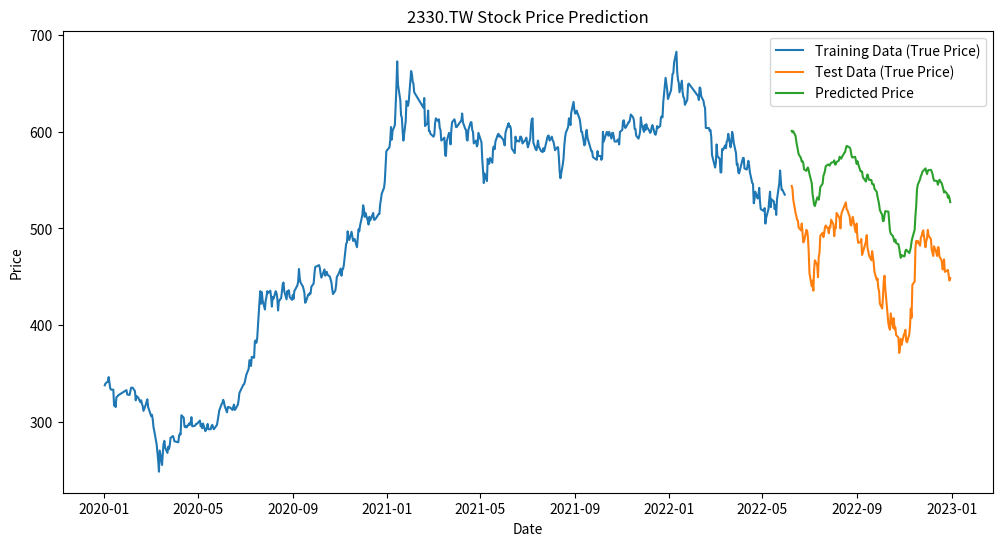

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 設定參數
ticker = '2330.TW'  # 台積電股票代號
n_days = 5  # 預測N日後的股價
train_ratio = 0.8  # 訓練集比例

# 抓取股票數據
stock_data = yf.download(ticker, start='2020-01-01', end='2023-01-01')
stock_data = stock_data[['Close']]  # 只使用收盤價

# 資料標準化
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(stock_data)

# 製作資料集
# 修改 create_dataset 讓 X 的形狀為 (batch_size, n_days)
def create_dataset(data, n_days):
    X, y = [], []
    for i in range(len(data) - n_days):
        X.append(data[i:i + n_days].flatten())  # 展平後成為一個向量
        y.append(data[i + n_days])
    return np.array(X), np.array(y)


X, y = create_dataset(scaled_data, n_days)

# 資料切分為訓練集和測試集
train_size = int(len(X) * train_ratio)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 轉換為 PyTorch tensor
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

# 定義線性模型
class LinearModel(nn.Module):
    def __init__(self, input_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)
    
    def forward(self, x):
        return self.linear(x)

# 建立模型
model = LinearModel(n_days)
criterion = nn.MSELoss()  # 使用均方誤差作為損失函數
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練模型
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

# 測試模型
model.eval()
with torch.no_grad():
    predicted_train = model(X_train).numpy()
    predicted_test = model(X_test).numpy()

# 反標準化
predicted_train = scaler.inverse_transform(predicted_train)
predicted_test = scaler.inverse_transform(predicted_test)
y_train = scaler.inverse_transform(y_train.numpy().reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

# 畫圖
# 調整索引來匹配 y_test 的長度
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index[:train_size], y_train, label='Training Data (True Price)')
plt.plot(stock_data.index[train_size + n_days:], y_test, label='Test Data (True Price)')
plt.plot(stock_data.index[train_size + n_days:], predicted_test, label='Predicted Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()



# 作業2

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import yfinance as yf
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
import os

# set plt font for linux
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP']  # 設定字型為 Noto Sans CJK JP
plt.rcParams['axes.unicode_minus'] = False  # 解決座標軸負號顯示問題

# 設定參數
ticker = '2330.TW'  # 台積電股票代號
n_days = 30  # 使用 N 天的 K 線圖進行預測
train_ratio = 0.8  # 訓練集比例
image_folder = 'kline_images'  # 圖片儲存資料夾
result_folder = 'result_images'  # 結果圖片儲存資料夾

# 建立資料夾
if not os.path.exists(image_folder):
    os.makedirs(image_folder)
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

# 使用 CUDA，如果可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 抓取股票數據
stock_data = yf.download(ticker, start='2020-01-01', end='2023-01-01')

# 計算均線
stock_data['SMA_5'] = stock_data['Close'].rolling(window=5).mean()
stock_data['SMA_10'] = stock_data['Close'].rolling(window=10).mean()

# 標註漲跌：5日均線高於10日均線標註為漲，否則為跌
stock_data['Label'] = (stock_data['SMA_5'] > stock_data['SMA_10']).astype(int)

# 繪製 K 線圖並存為圖像
for i in range(n_days, len(stock_data)):
    data = stock_data.iloc[i - n_days:i]
    label = stock_data.iloc[i]['Label']
    
    fig, ax = plt.subplots()
    mpf.plot(data, type='candle', mav=(5, 10), ax=ax, volume=False)
    ax.axis('off')  # 關閉坐標軸
    plt.savefig(f"{image_folder}/kline_{i}_{label}.png", bbox_inches='tight', pad_inches=0)
    plt.close()


[*********************100%***********************]  1 of 1 completed


Using device: cuda


In [18]:
# 定義 Dataset
class KLineDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = os.listdir(image_folder)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        label = int(self.image_files[idx].split('_')[-1].split('.')[0])  # 取得 label (漲/跌)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label, img_name  # 回傳圖像名稱

# 轉換和加載數據
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

dataset = KLineDataset(image_folder=image_folder, transform=transform)
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 定義 CNN 模型
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)  # 二分類：漲或跌

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)  # 展平
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 建立模型
model = CNN().to(device)  # 模型移動到 GPU 或 CPU
criterion = nn.CrossEntropyLoss()  # 使用交叉熵損失
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練模型
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels, _ in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")  

Epoch 1/10, Loss: 0.7008
Epoch 2/10, Loss: 0.6658
Epoch 3/10, Loss: 0.5561
Epoch 4/10, Loss: 0.3960
Epoch 5/10, Loss: 0.3358
Epoch 6/10, Loss: 0.2927
Epoch 7/10, Loss: 0.2364
Epoch 8/10, Loss: 0.2157
Epoch 9/10, Loss: 0.2138
Epoch 10/10, Loss: 0.1752


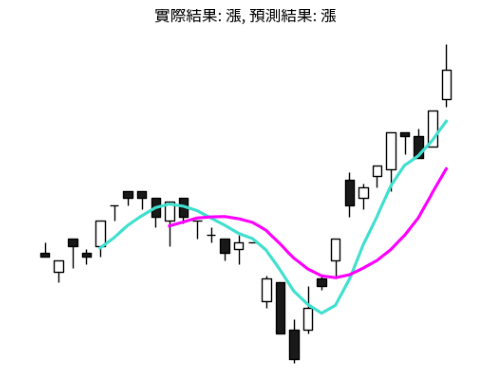

Accuracy: 85.11%


In [19]:
# 測試模型並儲存結果圖片
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels, img_names in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 針對每張圖片，顯示結果並存檔
        for i in range(inputs.size(0)):
            img_name = img_names[i]
            actual = "漲" if labels[i].item() == 1 else "跌"
            prediction = "漲" if predicted[i].item() == 1 else "跌"
            
            # 隨機打開一張原始 K 線圖，並將預測結果顯示在圖片上
            img = Image.open(img_name)
            plt.imshow(img)
            plt.title(f'實際結果: {actual}, 預測結果: {prediction}')
            plt.axis('off')  # 關閉坐標軸
            plt.savefig(f"{result_folder}/result_{os.path.basename(img_name)}", bbox_inches='tight', pad_inches=0)
            plt.close()

# 隨機抽一張result圖片顯示
result_img = Image.open(f"{result_folder}/{os.listdir(result_folder)[0]}")
plt.imshow(result_img)
plt.axis('off')  # Turn off axes
plt.show()
print(f'Accuracy: {100 * correct / total:.2f}%')